In [1]:
from data_loader import SliceDataLoader

slice_data_loader = SliceDataLoader(mode="intra")
slice_data_loader.prepare()

Prepared data:
 - Train: 51 slices
 - Val: 1 slices
 - Test: 1 slices


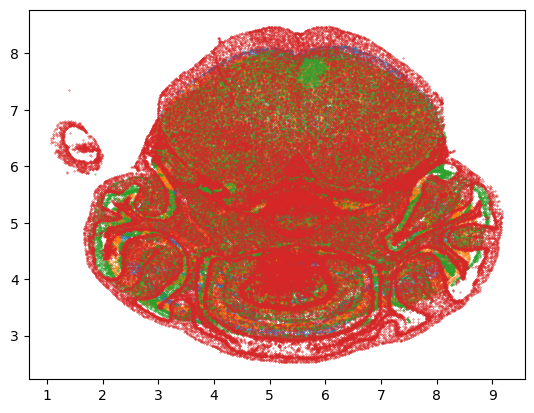

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(slice_data_loader.train_slices[0].obsm["original_spatial"][:,0],slice_data_loader.train_slices[0].obsm["original_spatial"][:,1],s=0.1)
plt.scatter(slice_data_loader.train_slices[1].obsm["original_spatial"][:,0],slice_data_loader.train_slices[1].obsm["original_spatial"][:,1],s=0.1)
plt.scatter(slice_data_loader.train_slices[2].obsm["original_spatial"][:,0],slice_data_loader.train_slices[2].obsm["original_spatial"][:,1],s=0.1)
plt.scatter(slice_data_loader.train_slices[3].obsm["original_spatial"][:,0],slice_data_loader.train_slices[3].obsm["original_spatial"][:,1],s=0.1)

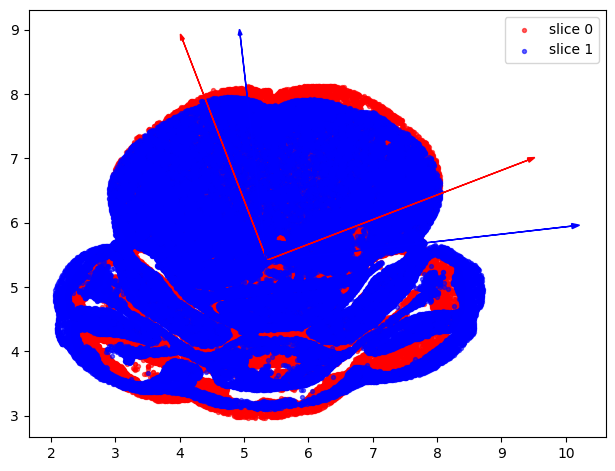

In [51]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def plot_it(coords, ax, color, label):
    """Scatter + PCA arrows on a supplied axis."""
    X = coords - coords.mean(axis=0)
    pca = PCA(n_components=2).fit(X)

    # scatter points
    ax.scatter(coords[:, 0], coords[:, 1], s=8, alpha=0.6, color=color, label=label)

    # PCA arrows
    origin = coords.mean(axis=0)
    for var, vec in zip(pca.explained_variance_, pca.components_):
        length = np.sqrt(var)
        ax.arrow(origin[0], origin[1],
                 vec[0] * length * 3,
                 vec[1] * length * 3,
                 width=0.0,
                 head_width=0.05 * length,
                 color=color,
                 zorder=3)

# get the two slices
coords1 = slice_data_loader.train_slices[0].obsm["original_spatial"]
coords2 = slice_data_loader.train_slices[1].obsm["original_spatial"]

# one shared figure/axis
fig, ax = plt.subplots()
plot_it(coords1, ax, color="red",   label="slice 0")
plot_it(coords2, ax, color="blue",  label="slice 1")

ax.set_aspect("equal")
ax.legend()
plt.tight_layout()
plt.show()


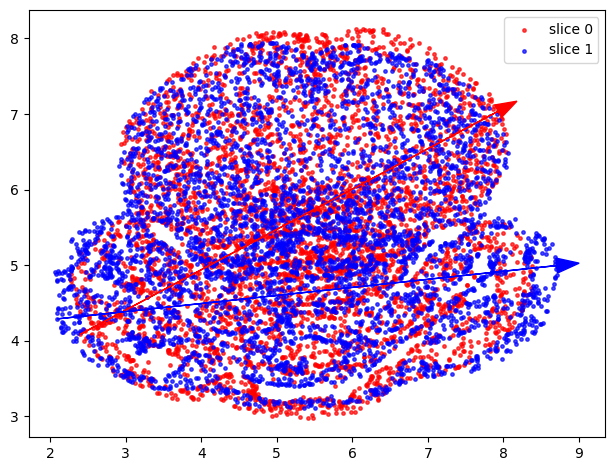

In [57]:
import numpy as np
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt


def plot_it(coords, ax, color, label, frac=0.01, rng=None):
    """
    Sample a small fraction of points, scatter them, and
    connect the farthest–apart pair inside that sample.
    """
    if rng is None:
        rng = np.random.default_rng()

    n  = coords.shape[0]
    m  = max(2, int(np.ceil(n * frac)))      # at least 2 points
    idx_sample = rng.choice(n, size=m, replace=False)
    sub = coords[idx_sample]                 # (m, 2) sample cloud

    # scatter ONLY the sample
    ax.scatter(sub[:, 0], sub[:, 1],
               s=6, alpha=0.7, color=color, label=label)

    # farthest pair inside the sample
    dists      = pdist(sub)
    # indices of upper‑triangular entries (k=1 skips the diagonal)
    iu, ju       = np.triu_indices(m, k=1)
    max_idx      = dists.argmax()
    i_sub, j_sub = iu[max_idx], ju[max_idx]

    p1, p2       = sub[i_sub], sub[j_sub]

    ax.arrow(p1[0], p1[1],
             p2[0] - p1[0],
             p2[1] - p1[1],
             width=0.0,
             head_width=0.03 * np.linalg.norm(p2 - p1),
             color=color, zorder=3)


coords1 = slice_data_loader.train_slices[0].obsm["original_spatial"]
coords2 = slice_data_loader.train_slices[1].obsm["original_spatial"]

fig, ax = plt.subplots()
plot_it(coords1, ax, color="red",  label="slice 0", frac=0.1)   # 1 % sample
plot_it(coords2, ax, color="blue", label="slice 1", frac=0.1)

ax.set_aspect("equal")
ax.legend()
plt.tight_layout()
plt.show()


/tmp/ipykernel_3392471/2634978808.py:53: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


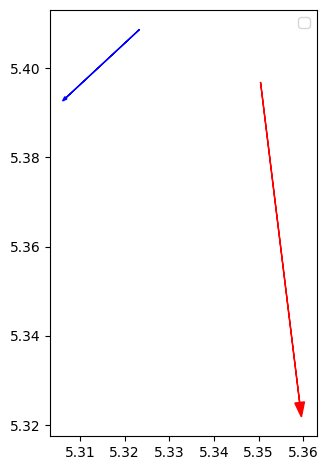

In [74]:
import numpy as np
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt


def geometric_median(points, tol=1e-5, max_iter=100000):
    """Weiszfeld iteration."""
    y = points.mean(axis=0)
    for _ in range(max_iter):
        d = np.linalg.norm(points - y, axis=1)
        if (d == 0).any():                # y is exactly on a point
            return y
        w = 1.0 / d
        y_new = (points * w[:, None]).sum(axis=0) / w.sum()
        if np.linalg.norm(y_new - y) < tol:
            return y_new
        y = y_new
    return y


def plot_it(coords, ax, color, label, frac=0.01, rng=None):
    """Scatter a sample; arrow from mean → geometric median."""
    if rng is None:
        rng = np.random.default_rng()

    n  = coords.shape[0]
    m  = max(2, int(np.ceil(n * frac)))
    sub_idx = rng.choice(n, size=m, replace=False)
    sub = coords[sub_idx]                    # (m, 2)

    # scatter the sample
    # ax.scatter(sub[:, 0], sub[:, 1], s=6, alpha=0.7, color=color, label=label)

    mean_pt   = sub.mean(axis=0)
    med_pt    = geometric_median(sub)

    ax.arrow(mean_pt[0], mean_pt[1],
             med_pt[0] - mean_pt[0],
             med_pt[1] - mean_pt[1],
             width=0.0,
             head_width=0.03 * np.linalg.norm(med_pt - mean_pt),
             color=color, zorder=3)


coords1 = slice_data_loader.train_slices[0].obsm["original_spatial"]
coords2 = slice_data_loader.train_slices[1].obsm["original_spatial"]

fig, ax = plt.subplots()
plot_it(coords1, ax, color="red",  label="slice 0", frac=0.1)
plot_it(coords2, ax, color="blue", label="slice 1", frac=0.1)

ax.set_aspect("equal")
ax.legend()
plt.tight_layout()
plt.show()


/tmp/ipykernel_3392471/2041821159.py:64: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


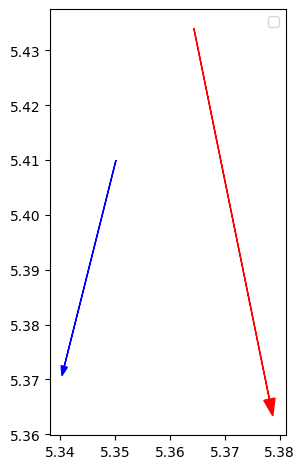

In [77]:
import numpy as np
from scipy.spatial.distance import pdist
from scipy.optimize import minimize

# ---------- Oja median --------------------------------------------------------
def _oja_objective(p, pts):
    """
    Return Σ ½| (p_i - p) × (p_j - p) | over all unordered pairs (i<j).
    Complexity O(m²) for m points.
    """
    diff = pts - p                         # (m,2)
    dx, dy = diff[:, 0], diff[:, 1]
    cross  = np.abs(np.outer(dx, dy) - np.outer(dy, dx))  # (m,m)
    # upper‑triangular sum excludes i=j and double‑counting
    return 0.5 * cross[np.triu_indices_from(cross, k=1)].sum()


def oja_median(points, tol=1e-5):
    """
    Nelder–Mead search for the Oja median in 2‑D.
    Use the sample mean as the starting point.
    """
    start = points.mean(axis=0)
    res = minimize(_oja_objective,
                   x0=start,
                   args=(points,),
                   method="Nelder-Mead",
                   tol=tol,
                   options={"maxiter": 5000, "xatol": tol, "fatol": tol})
    return res.x
# ------------------------------------------------------------------------------


def plot_it(coords, ax, color, label, frac=0.01, rng=None):
    if rng is None:
        rng = np.random.default_rng()

    n  = coords.shape[0]
    m  = max(2, int(np.ceil(n * frac)))
    idx = rng.choice(n, size=m, replace=False)
    sub = coords[idx]

    # ax.scatter(sub[:, 0], sub[:, 1], s=6, alpha=0.7, color=color, label=label)

    mean_pt = sub.mean(axis=0)
    oja_pt  = oja_median(sub)

    ax.arrow(mean_pt[0], mean_pt[1],
             oja_pt[0] - mean_pt[0],
             oja_pt[1] - mean_pt[1],
             width=0.0,
             head_width=0.03 * np.linalg.norm(oja_pt - mean_pt),
             color=color, zorder=3)


coords1 = slice_data_loader.train_slices[0].obsm["original_spatial"]
coords2 = slice_data_loader.train_slices[1].obsm["original_spatial"]

fig, ax = plt.subplots()
plot_it(coords1, ax, color="red",  label="slice 0", frac=0.1)
plot_it(coords2, ax, color="blue", label="slice 1", frac=0.1)

ax.set_aspect("equal")
ax.legend()
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
from sklearn.decomposition import PCA

# ---------- core alignment routine (axes-to-axes) ---------------------------
def align_by_pc_axes(slice1, slice2, n_components=2):
    """
    Align slice1 to slice2 by matching their top-k PCA axes.

    Returns
    -------
    slice1_aligned : AnnData (copy with updated obsm['spatial'])
    slice2_copy    : AnnData (unchanged copy)
    M              : (d x d) alignment matrix
    """

    X1 = slice1.obsm['spatial']
    X2 = slice2.obsm['spatial']

    # centre each slice
    mu1, mu2 = X1.mean(axis=0), X2.mean(axis=0)
    X1c, X2c = X1 - mu1, X2 - mu2

    # PCA on centred coordinates
    pca1 = PCA(n_components=n_components).fit(X1c)
    pca2 = PCA(n_components=n_components).fit(X2c)

    V1 = pca1.components_          # shape (k, d)
    V2 = pca2.components_

    # linear map that sends axes of slice1 to axes of slice2
    #  minimise || V1 M - V2 ||_F  →  M = V2 V1^T  (orthogonal if k = d = 2)
    M = V2.T @ V1                  # (d x d)   2‑D case: pure rotation/reflection

    # apply to original coords
    X1_aligned = (X1c @ M) + mu2

    # wrap into AnnData copies
    slice1_aligned = slice1.copy()
    slice1_aligned.obsm['spatial'] = X1_aligned
    slice2_copy = slice2.copy()

    return slice1_aligned, slice2_copy, M
# ---------------------------------------------------------------------------


# ---------- projection / propagation loop ---------------------------------
projected_coordinates = {0: {}}        # store all aligned coords

num_links = 4  # adjust to len(train_slices)-1 in real code
for i in range(num_links):
    s1 = slice_data_loader.train_slices[i]
    s2 = slice_data_loader.train_slices[i + 1]

    # 1. align current pair
    s1_aligned, s2_copy, M = align_by_pc_axes(s1, s2, n_components=1)

    # 2. store the freshly aligned coords for slice i under key (i+1)
    projected_coordinates[i + 1] = {i: s1_aligned.obsm['spatial']}

    # 3. propagate all previous projections through the same map
    for prev_idx, X_prev in projected_coordinates[i].items():
        X_prev_aligned = (X_prev - X_prev.mean(axis=0)) @ M + s2.obsm['spatial'].mean(axis=0)
        projected_coordinates[i + 1][prev_idx] = X_prev_aligned
# ---------------------------------------------------------------------------





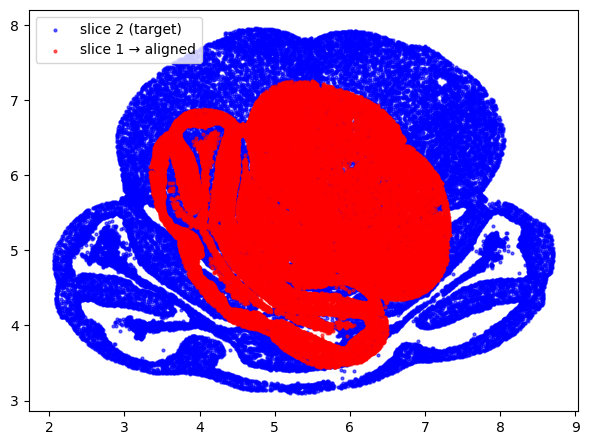

In [78]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# ---------- Oja median (2‑D, Nelder–Mead) ----------
def _oja_obj(p, P):
    diff = P - p                 # (m,2)
    cross = np.abs(np.outer(diff[:,0], diff[:,1]) -
                   np.outer(diff[:,1], diff[:,0]))
    return 0.5 * cross[np.triu_indices_from(cross, k=1)].sum()

def oja_median(P, tol=1e-5):
    res = minimize(_oja_obj, x0=P.mean(axis=0), args=(P,),
                   method="Nelder-Mead",
                   tol=tol, options={"maxiter": 4000})
    return res.x
# ---------------------------------------------------

def affine_from_arrows(mu1, oja1, mu2, oja2):
    """Return 2×2 matrix A such that A·(oja1-mu1) = (oja2-mu2)."""
    v1  = oja1 - mu1
    v2  = oja2 - mu2
    # perpendiculars
    v1p = np.array([-v1[1], v1[0]])
    v2p = np.array([-v2[1], v2[0]])
    B1  = np.column_stack((v1, v1p))   # 2×2
    B2  = np.column_stack((v2, v2p))   # 2×2
    return B2 @ np.linalg.inv(B1)      # 2×2

def sample_stats(coords, frac=0.1, rng=None):
    if rng is None:
        rng = np.random.default_rng()
    n  = coords.shape[0]
    m  = max(20, int(np.ceil(n * frac)))
    sub = coords[rng.choice(n, size=m, replace=False)]
    mu  = sub.mean(axis=0)
    oja = oja_median(sub)
    return mu, oja

# ------------ slices ----------------------------------------------------------
coords1 = slice_data_loader.train_slices[0].obsm["original_spatial"]
coords2 = slice_data_loader.train_slices[1].obsm["original_spatial"]

mu1, oja1 = sample_stats(coords1, frac=0.1)
mu2, oja2 = sample_stats(coords2, frac=0.1)

A = affine_from_arrows(mu1, oja1, mu2, oja2)

# transform *all* points of slice 1
coords1_aff = (coords1 - mu1) @ A.T + mu2     # (n1,2)

# ------------------- plot ---------------------------------
fig, ax = plt.subplots(figsize=(6,6))

ax.scatter(coords2[:,0],     coords2[:,1],
           s=4, alpha=0.6, label="slice 2 (target)", color="blue")
ax.scatter(coords1_aff[:,0], coords1_aff[:,1],
           s=4, alpha=0.6, label="slice 1 → aligned", color="red")

ax.set_aspect("equal")
ax.legend()
plt.tight_layout()
plt.show()


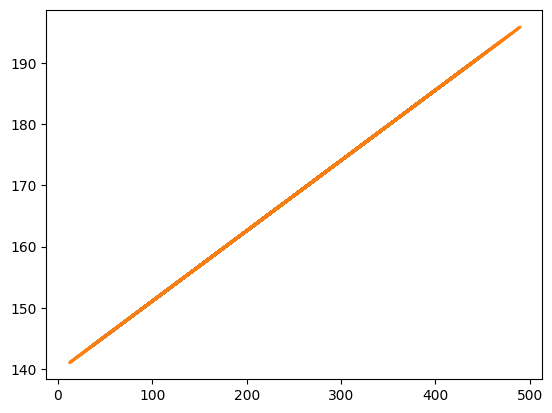

In [42]:
plt.scatter(projected_coordinates[2][0][:,0],projected_coordinates[2][0][:,1],s=0.1)
plt.scatter(projected_coordinates[2][1][:,0],projected_coordinates[2][1][:,1],s=0.1)

In [20]:
projected_coordinates[len(slice_data_loader.train_slices)-1][0]

array([[5.40361906, 5.36757714],
       [5.40361906, 5.36757714],
       [5.40361906, 5.36757714],
       ...,
       [5.40361906, 5.36757714],
       [5.40361906, 5.36757714],
       [5.40361906, 5.36757714]])

In [21]:
projected_coordinates[len(slice_data_loader.train_slices)-1][0][:,0]

array([5.40361906, 5.40361906, 5.40361906, ..., 5.40361906, 5.40361906,
       5.40361906])

In [28]:
projected_coordinates

{0: {},
 1: {0: array([[7.04939333, 7.67283388],
         [4.45008052, 7.63069392],
         [6.73295628, 5.66988135],
         ...,
         [7.11801973, 3.59233163],
         [5.58477707, 7.98877266],
         [5.7589879 , 4.11650718]])},
 2: {1: array([[7.03340763, 7.24725145],
         [5.36241248, 6.05978437],
         [5.39750713, 6.13550814],
         ...,
         [7.51177077, 6.35231607],
         [4.59722819, 6.87164228],
         [7.30582069, 6.52996037]]),
  0: array([[5.58567621, 5.96565905],
         [5.63234803, 6.16725657],
         [5.40310738, 5.34832725],
         ...,
         [5.19984204, 4.64896748],
         [5.64398167, 6.18838746],
         [5.2757121 , 4.92986074]])}}